In [1]:
import re

import io
from tqdm import tqdm

import pandas as pd
import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import emoji

import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
parameters = {}
parameters['embedding_name'] = './embeddings/glove.twitter.27B.100d.txt'
parameters['classes'] = ['anger', 'joy', 'sadness', 'fear']
parameters['save_path'] = 'models/wassa_lstm_embeddings/'

In [3]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [4]:
def load_glove(fname):
    embeddings_index = {}
    with open(fname, encoding="utf8") as f:
        for line in tqdm(f):
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    
    return embeddings_index

## Loading the embeddings 

In [5]:
embedding_index = load_glove(parameters['embedding_name'])
print('Number of word vectors : ', len(embedding_index))

1193514it [00:54, 21936.68it/s]

Number of word vectors :  1193514


## Reading and Pre-processing

In [6]:
base_path = '../Data/wassa_data/'

In [7]:
class_mapping = {}

for idx, name in enumerate(parameters['classes']):
    class_mapping[name] = idx 
    
no_classes = len(parameters['classes'])

In [8]:
cols = ['tweet', 'tweettype']

In [9]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [10]:
import codecs
import unidecode
import re
import spacy

nlp = spacy.load('en')

def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [11]:
def clean_text(data):
    data = (re.sub(r"(#[\d\w\.]+)", '', data)).lower()
    data = emoji.demojize(data)
    data = spacy_cleaner(data)
    return data

In [12]:
def build_dataset(df, feature='text', target='label'):
    dataset = (
                tf.data.Dataset.from_tensor_slices(
                    (
                        tf.cast(df[feature].values, tf.string),
                        tf.cast(df[target].values, tf.int32)
                    )
                )
            )
    return dataset

In [13]:
def load_dataset(directory, ending, threshold = 0, testing = False):

    df_list = []

    for emotion in parameters['classes']:
        file_name = f'{base_path}{directory}/{emotion}{ending}'
        df = pd.read_csv(file_name, delimiter='\t')
        
        stop = stopwords.words('english')
        df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        
        if not testing:
            df = df[df['score'] > threshold]
        
        df = df[cols]
        
        df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        df['tweet'] = df['tweet'].apply(clean_text)        
        df['tweettype'] = df['tweettype'].apply(lambda x : class_mapping[x])        

        df_list.append(df)

    df = pd.concat(df_list)
    df = df.rename(columns = {'tweet' : 'text', 'tweettype' : 'label'})
    print('Distribution of data: ')
    print(df['label'].value_counts())
    
    labels = df['label'].values
    
    dataset = build_dataset(df)
    
    return dataset, labels, df

In [14]:
# Training
threshold = 0

directory = 'training'
ending = '-ratings-0to1.train.txt'

train_dataset,_, df_train = load_dataset(directory, ending, threshold = threshold)

Distribution of data: 
3    1147
0     857
1     823
2     786
Name: label, dtype: int64


In [15]:
# Validation

directory = 'validation'
ending = '-ratings-0to1.dev.gold.txt'

val_dataset,_, df_val = load_dataset(directory, ending)

Distribution of data: 
3    110
0     84
1     79
2     74
Name: label, dtype: int64


In [16]:
# Testing

directory = 'testing'
ending = '-ratings-0to1.test.target.txt'

test_dataset, y_test, df_test = load_dataset(directory, ending, testing = True)

Distribution of data: 
3    995
0    760
1    714
2    673
Name: label, dtype: int64


In [17]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=100)
vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [18]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'be', 'get', 'not']

In [19]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [20]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 5715 words (568 misses)


In [21]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [22]:
x_train = vectorizer(np.array([[s] for s in list(df_train.text)])).numpy()
x_val = vectorizer(np.array([[s] for s in list(df_val.text)])).numpy()

y_train = np.array(list(df_train.label))
y_val = np.array(list(df_val.label))

In [23]:
x_train[0]

array([ 114, 2720,  183, 2658,  201, 2726, 1088, 2552, 1125,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int64)

In [24]:
from tensorflow.keras import layers

int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
embedded_sequences.trainable = False 

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedded_sequences)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

preds = layers.Dense(no_classes, activation="softmax")(x)

model = tf.keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         628500    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
dense (Dense)                (None, None, 128)         16512     
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 4)           516   

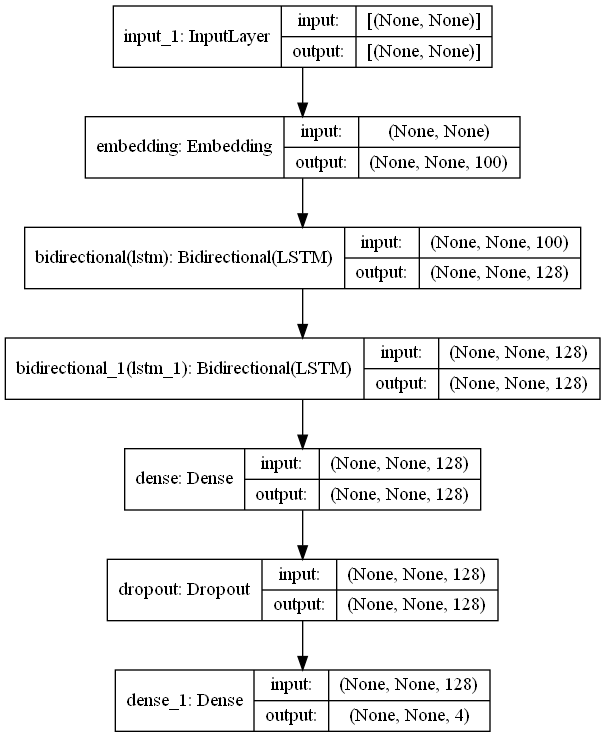

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [26]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class CustomCallback(Callback):
    def __init__(self, validation_data=None):
        super(CustomCallback, self).__init__()
        self.validation_data = validation_data
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):        
        val_predict = (np.asarray(self.model.predict(self.validation_data[0])))
        val_predict = [np.argmax(i) for i in val_predict]
        
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average = 'weighted')
        _val_recall = recall_score(val_targ, val_predict, average = 'weighted')
        _val_precision = precision_score(val_targ, val_predict, average = 'weighted')
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print("— val_f1: %f — val_precision: %f — val_recall %f"%(_val_f1, _val_precision, _val_recall))
        return

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=128,
                    epochs=20, validation_data=(x_val, y_val),
                    callbacks = [CustomCallback(validation_data = (x_val, y_val))])

Epoch 1/20


InvalidArgumentError:  assertion failed: [Condition x == y did not hold element-wise:] [x (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [128 1] [y (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [128 100]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert (defined at <ipython-input-27-e8bbc4b0871a>:3) ]] [Op:__inference_train_function_11082]

Function call stack:
train_function


In [ ]:
plt.figure(1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

## Evaluation against test

In [ ]:
model.load_weights(parameters['save_path'])

In [ ]:
x_test = vectorizer(np.array([[s] for s in list(df_test.text)])).numpy()
y_test = np.array(list(df_test.label))

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
pred = model.predict(x_test)

pred_idx = []

for i in tqdm(range(len(pred))):
    pred_idx.append(np.argmax(pred[i]))

In [ ]:
print(classification_report(y_test, pred_idx, target_names=parameters['classes']))

In [ ]:
print(confusion_matrix(y_test, pred_idx))